### we are going to train our model on tesla stock price of year 2016-2020 and test/predict on 2021(till 7th may)
###    data source : [tesla](https://in.finance.yahoo.com/quote/TSLA?p=TSLA&.tsrc=fin-srch), Let's get started

# Part 1 - Data Preprocessing

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Imporing the training set

In [2]:
dataset_train = pd.read_csv('../input/teslastock/teslastock/tesla train.csv')

### Checking first 5 records of training set

In [3]:
dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,04-01-16,46.144001,46.276001,43.799999,44.681999,44.681999,34135500
1,05-01-16,45.271999,45.377998,44.000000,44.686001,44.686001,15934000
2,06-01-16,44.000000,44.009998,43.195999,43.807999,43.807999,18895500
3,07-01-16,42.838001,43.688000,42.734001,43.130001,43.130001,17771500
4,08-01-16,43.571999,44.088001,42.153999,42.200001,42.200001,18140500


### Checking for Null values

In [4]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [5]:
dataset_train.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,102.614993,105.004135,100.148915,102.807852,102.807852,4.381518e+07
std,120.378191,123.776691,116.843998,121.022725,121.022725,3.075866e+07
min,28.464001,30.993999,28.209999,28.733999,28.733999,8.297500e+06
25%,47.270001,48.084999,46.517000,47.531001,47.531001,2.389275e+07
50%,61.500000,62.745998,60.375999,61.740002,61.740002,3.447200e+07
75%,71.603001,72.944999,70.424999,71.514000,71.514000,5.204630e+07
max,699.989990,718.719971,691.119995,705.669983,705.669983,3.046940e+08


#### Now we only select second column of the dataset_train which is **Open** and convert into numpy array using values method

In [6]:
training_set = dataset_train.iloc[:, 1:2].values

In [7]:
training_set

array([[ 46.144001],
       [ 45.271999],
       [ 44.      ],
       ...,
       [661.      ],
       [672.      ],
       [699.98999 ]])

In [8]:
training_set.shape

(1259, 1)

## Feature Scaling
*  there are mainly two ways to feature scaling
   1. Standardisation  
   2. Normalization 
* in our case we gonna use normalization and specifically minmax scaler and the idea behind that is since we gonna create RNN and in this network we use sigmoid activation function in output layer.so it's great to values lies between 0 to 1 and minmax scaler exactly doing same

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

## Creating a data structure with 70 timesteps and 1 output
* we'll take 70 timestamps, first of for whats timestemp? since we gonna predict stock price(Open) so timestamp of 70 is saying that when you predict stock price at any given day at that time consider last 70 day's stock price to make prediction.
* then we create 2 numpy array X_train and y_train where X_train is containing stock price with last 70 days stock price values and y_train containing single day stock price at given day.

In [10]:
X_train = []
y_train = []
for i in range(70, 1259):
    X_train.append(training_set_scaled[i-70:i,0])
    y_train.append(training_set_scaled[i,0])
#converting lists into numpy array for smooth procedures
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
X_train.shape

(1189, 70)

In [12]:
y_train.shape

(1189,)

## Reshaping
* we have to convert into rnn standard format X_train into 3D tensor with shape(batch_size, timestemps, output_size)
* let's see each perameters values for our model
1. batch_size: No of Observation(X_train.shape[0] which is 1189)
2. timestems: 70 as we initialized above(X_train.shape[1])
3. input_dim: 1 since we gonna predict only one varibale google stock price

In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [14]:
X_train.shape

(1189, 70, 1)

# Part 2 - Building the RNN

In [15]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

### Initializing the RNN

In [16]:
regressor = Sequential()

### Adding a first LSTM layers and some Dropout Regularization

* units : number of neurons we choose 55
* return_sequences: choose **True** because we are gonna add another lstm layer after this one
* input_shape: it will take 2d array(timestemps and indicator(no of predictor) and the value would be **(X_train.shape[1], 1)**
* Dropout Layer : we give it to 0.2 means 20%, that means drop the 20 percent(11 neurons) of neurons which are least involving.
* **NOTE**: Dropout is used to Prevent **Overfitting**

In [17]:
regressor.add(LSTM(units=55, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

### Adding the second LSTM layer and some Dropout regularization
* after first lstm layer we dont need to specify input_shape

In [18]:
regressor.add(LSTM(units=55, return_sequences=True))
regressor.add(Dropout(0.2))

### Adding the third LSTM layer and some Dropout Regularization
* no need to add return sequences in the last lstm layer

In [19]:
regressor.add(LSTM(units=55))
regressor.add(Dropout(0.2))

## Adding the output layer
* units: 1 since we predict only one value

In [20]:
regressor.add(Dense(1))

## Compiling the RNN

* optimizer: **adam** is always a safe choice or you can use **RMSprop** which is also a good choice for RNN
* loss: since we have a regression problem we gonna use **mean_squared_error**

In [21]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

## Fitting the RNN to the Training Set

In [22]:
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 8s 93ms/step - loss: 0.0155
Epoch 2/100
38/38 [==============================] - 4s 93ms/step - loss: 0.0015
Epoch 3/100
38/38 [==============================] - 4s 94ms/step - loss: 0.0014
Epoch 4/100
38/38 [==============================] - 4s 94ms/step - loss: 0.0018
Epoch 5/100
38/38 [==============================] - 3s 92ms/step - loss: 0.0020
Epoch 6/100
38/38 [==============================] - 3s 92ms/step - loss: 0.0012
Epoch 7/100
38/38 [==============================] - 4s 93ms/step - loss: 0.0014
Epoch 8/100
38/38 [==============================] - 4s 98ms/step - loss: 0.0015
Epoch 9/100
38/38 [==============================] - 4s 93ms/step - loss: 8.0456e-04
Epoch 10/100
38/38 [==============================] - 4s 94ms/step - loss: 0.0028
Epoch 11/100
38/38 [==============================] - 4s 93ms/step - loss: 0.0014
Epoch 12/100
38/38 [==============================] - 4s 92ms/step - loss: 0.0011
Epoch 13/100
38/38 [=

# Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2021 which we gonna predict

In [23]:
dataset_test = pd.read_csv('../input/teslastock/teslastock/tesla test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### Getting the predicted stock price of 2021
### 3 Key Points
1. we trained our model to be able to predict the stock price at time t+1 based on the 70 previous stock prices and therefore to predict each stock price of each financial day of 2021 we will need 70 previous stock prices of the 70 previous financial days, before the actual day.
2. in order to get day of 2021 the 70 previous stock prices of the 70 previous day, so we will need both the train set and test set because we will have some of the 70 days that will be from the testing set because they will be form november 2021 and december 2021 and we will also have some stock prices of the test set because some of them will come from 2021, and therefore first thing we need to do now is now some concatenation of training set and test set to be able to get these 70 previous inputs for each day of 2021.
3. we will have to concatenate both but we do not change the actual test values. so we have to concatenate orininal dataset.(we have to feed our model with scaling values but make prediction on actual values so we have to keep them)

In [24]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
inputs = dataset_total[len(dataset_total)-len(dataset_test)-70:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(70,157):
    X_test.append(inputs[i-70:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [25]:
predicted_stock_price

array([[637.77966],
       [653.2883 ],
       [665.18036],
       [682.3099 ],
       [700.16895],
       [735.9783 ],
       [759.0225 ],
       [763.87494],
       [770.0124 ],
       [771.32526],
       [774.38464],
       [772.54315],
       [777.4791 ],
       [780.96124],
       [776.6841 ],
       [779.30133],
       [793.90985],
       [798.3606 ],
       [783.5836 ],
       [774.3643 ],
       [765.4041 ],
       [769.8169 ],
       [785.46466],
       [789.9357 ],
       [787.1251 ],
       [791.58624],
       [791.18774],
       [786.5998 ],
       [773.55145],
       [760.8134 ],
       [758.37714],
       [747.4599 ],
       [739.5657 ],
       [739.55396],
       [731.5082 ],
       [695.1432 ],
       [679.5056 ],
       [679.1047 ],
       [675.1145 ],
       [668.26587],
       [671.1647 ],
       [666.3225 ],
       [651.50793],
       [630.49335],
       [607.6484 ],
       [594.01   ],
       [614.6525 ],
       [638.03296],
       [643.7301 ],
       [649.2776 ],


In [26]:
predicted_stock_price.shape

(87, 1)

## Visualizing the Result

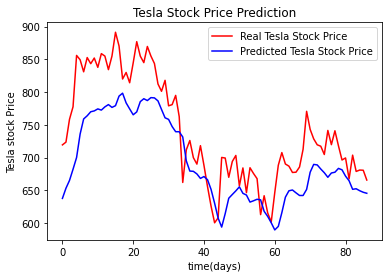

In [27]:
plt.plot(real_stock_price, color='red', label='Real Tesla Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Tesla Stock Price')
plt.title("Tesla Stock Price Prediction")
plt.xlabel('time(days)')
plt.ylabel('Tesla stock Price')
plt.legend()